In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from sklearn.preprocessing import MinMaxScaler


In [3]:
def normalize_dataframe(df):
    """
    Normalizes all columns in a pandas DataFrame  using MinMaxScaler.

    Args:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The normalized DataFrame.
    """
    scaler = MinMaxScaler()
    columns_to_normalize = [col for col in df.columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

In [4]:
def combine_csvs_from_folder(folder_path):
    """
    Combines all CSV files in a folder into a single pandas DataFrame also normalizes before combining them.

    Args:
        folder_path (str): The path to the folder containing the CSV files.

    Returns:
        A pandas DataFrame containing the concatenated data from all CSV files in the input folder.
    """
    # Use a list comprehension to read all CSV files in the folder into a list of DataFrames.
    dfs = [pd.read_csv(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith('.csv')]
    
    # Use a list comprehension to get the filenames of all CSV files in the folder.
    filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir(folder_path) if f.endswith('.csv')]

    processed_dfs = []
    i = 0
    for df, filename in zip(dfs, filenames):
        # Dont need the date column
        df = df.drop(['date'], axis=1)
        # normalize the dataframes before combining them
        df = normalize_dataframe(df)
        # for the neural network to understand the company name we need to convert it to a number
        df['company'] = i
        i += 1
        processed_dfs.append(df)
    combined_df = pd.concat(processed_dfs, ignore_index=True)
    
    return combined_df

df = combine_csvs_from_folder('market_data/merged_data')

df.tail()

,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,WMA,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,company
54006,0.828590,0.611121,0.124368,0.161278,0.721455,0.35,1.00,0.825,0.371731,0.908468,...,0.912402,0.789583,0.792715,0.795367,0.785348,0.915660,0.053093,0.0,0.0,10
54007,0.831386,0.613370,0.120646,0.147684,0.739753,0.30,0.95,0.825,0.361116,0.912497,...,0.915420,0.780175,0.785976,0.794163,0.787510,0.917801,0.047816,0.0,0.0,10
54008,0.832392,0.613550,0.109766,0.139020,0.741281,0.25,0.90,0.825,0.358681,0.914832,...,0.917420,0.777547,0.778555,0.786126,0.778268,0.908648,0.041491,0.0,0.0,10
54009,0.836382,0.618820,0.098034,0.135600,0.750070,0.20,0.85,0.825,0.349887,0.916590,...,0.919478,0.775004,0.777489,0.784578,0.780133,0.910496,0.049474,0.0,0.0,10
54010,0.838405,0.621768,0.096450,0.133156,0.760952,0.15,0.80,0.825,0.345329,0.918329,...,0.922155,0.781107,0.788834,0.792659,0.788697,0.918977,0.044220,0.0,0.0,10


In [5]:
#we need this for later
def find_indices_of_last_company_changes(df):
    indices = []
    for i in range(1, len(df)):
        if df.loc[i, 'company'] != df.loc[i - 1, 'company']:
            indices.append(i-1)
    return indices
idxs = find_indices_of_last_company_changes(df)
idxs.append(len(df) - 1)

In [6]:
# we should one hot encode the company column
# first we need to change it to a string so we can one hot encode it
df['company'] = df['company'].astype(str)
df = pd.get_dummies(df, columns=['company'])

In [7]:
def add_up_column(df):
    # Create empty 'up' and 'down' columns
    df['up'] = 0
    
    # Loop over the rows (skipping the first row)
    for i in range(1, len(df)):
        if df.loc[i, '4. close'] > df.loc[i-1, '4. close']:
            df.loc[i, 'up'] = 1
    return df


df = add_up_column(df)
df.head()


,Chaikin A/D,ADOSC,ADX,ADXR,APO,Aroon Down,Aroon Up,AROONOSC,ATR,Real Upper Band,...,company_10,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,up
0,0.172135,0.545425,0.154470,0.101243,0.502764,0.95,0.25,0.15,0.010778,0.004883,...,0,0,0,0,0,0,0,0,0,0
1,0.169640,0.532056,0.164471,0.106557,0.502062,0.90,0.20,0.15,0.010778,0.004920,...,0,0,0,0,0,0,0,0,0,0
2,0.173826,0.555077,0.164130,0.114041,0.502022,0.85,0.15,0.15,0.011184,0.004920,...,0,0,0,0,0,0,0,0,0,1
3,0.177859,0.590061,0.159311,0.123042,0.501608,0.80,0.10,0.15,0.011078,0.004897,...,0,0,0,0,0,0,0,0,0,1
4,0.173893,0.583195,0.149749,0.131813,0.501044,0.75,0.05,0.15,0.011167,0.004806,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# neural networks require tensors, so we need to convert our dataframes to tensors

def df_to_tensor(df):
    inputs_columns = df.columns[df.columns != 'up']
    inputs = torch.from_numpy(df.loc[:, inputs_columns].values.astype('float32'))
    targets = torch.from_numpy(df.loc[:, ['up']].values.astype('float32'))
    return inputs, targets


inputs, targets = df_to_tensor(df)
print(inputs[0])
print(inputs.shape)
print(targets.shape)

tensor([0.1721, 0.5454, 0.1545, 0.1012, 0.5028, 0.9500, 0.2500, 0.1500, 0.0108,
        0.0049, 0.0044, 0.0048, 0.6001, 0.3041, 0.3204, 0.0041, 0.3287, 0.0043,
        0.0770, 0.1221, 0.4935, 0.5869, 0.4913, 0.8474, 0.0045, 1.0000, 0.0041,
        0.4687, 0.4572, 0.5075, 0.5028, 0.4830, 0.5257, 0.0021, 0.0000, 0.4928,
        0.0043, 0.0044, 0.4145, 0.0082, 0.4762, 0.3511, 0.2082, 0.1884, 0.0058,
        0.7284, 0.5345, 0.5344, 0.3204, 0.0051, 0.0044, 0.1780, 0.2642, 0.3207,
        0.1780, 0.2269, 0.0756, 0.0045, 0.0039, 0.0067, 0.0046, 0.7760, 0.3548,
        0.1964, 0.0043, 0.1429, 0.1544, 0.1394, 0.1461, 0.0037, 0.0121, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
torch.Size([54011, 84])
torch.Size([54011, 1])


In [9]:
# making a training and validation dataset

dataset = TensorDataset(inputs, targets)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [10]:
# pytorch uses dataloaders to load data in batches

batch_size = 128
train_loader = DataLoader(dataset, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False, num_workers = 0)

In [11]:
# use gpu if avaliable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 1028),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1028, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_size), 
            nn.Sigmoid()
        )

        

    def forward(self, x):
        x = self.model(x)
        
        return x

# input size is 84 because we have 84 columns in our dataframe
# output size is 1 because we are predicting up=1 or down=0
input_size = 84
output_size = 1
model = NN(input_size, output_size)
model.to(device)

NN(
  (model): Sequential(
    (0): Linear(in_features=84, out_features=1028, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1028, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [13]:
# hyperparameters for training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
num_epochs = 200

In [14]:
# training loop
training_losses = []
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #average the loss over all batches
    avg_loss = epoch_loss / len(train_loader)
    training_losses.append(avg_loss)
    if(epoch % 10 == 0 or epoch == 1):
        print(f'epoch: {epoch}, avg_loss: {avg_loss}')

epoch: 1, avg_loss: 0.303484126819536
epoch: 10, avg_loss: 0.20918286540567593
epoch: 20, avg_loss: 0.17220415558083363
epoch: 30, avg_loss: 0.1596113585235807
epoch: 40, avg_loss: 0.14491644329545905
epoch: 50, avg_loss: 0.13134647138699254
epoch: 60, avg_loss: 0.11582166510435501
epoch: 70, avg_loss: 0.10503099834926038
epoch: 80, avg_loss: 0.09256583033350266
epoch: 90, avg_loss: 0.08954706468500233
epoch: 100, avg_loss: 0.08050816212626288
epoch: 110, avg_loss: 0.07606412046390335
epoch: 120, avg_loss: 0.06699506435719853
epoch: 130, avg_loss: 0.06847824802472129
epoch: 140, avg_loss: 0.0630108983039644
epoch: 150, avg_loss: 0.06093426650363546
epoch: 160, avg_loss: 0.05586067520708764
epoch: 170, avg_loss: 0.05400565131986734
epoch: 180, avg_loss: 0.05544498840885422
epoch: 190, avg_loss: 0.0499672413951501
epoch: 200, avg_loss: 0.04650121606595073


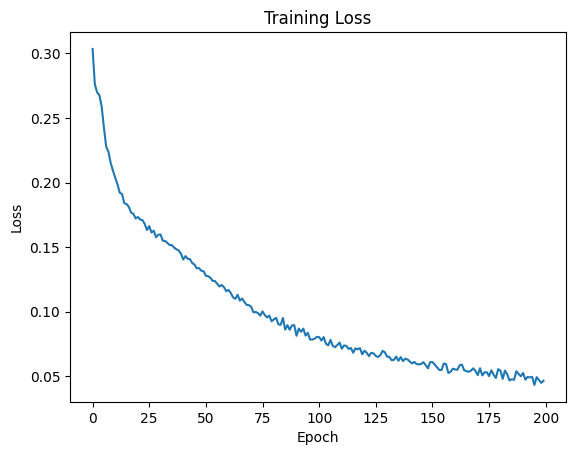

In [15]:
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [16]:
def validate(model, dataloader, criterion):
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Disable gradient calculation for efficiency
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device) # Move data to GPU if available
            outputs = model(inputs)
            loss = criterion(outputs, targets.float()) # BCE loss expects float inputs
            val_loss += loss.item() * inputs.size(0) # Track total validation loss
            
            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(dataloader.dataset)
    accuracy = correct / total
    
    return val_loss, accuracy

val_loss, val_acc = validate(model, val_loader, criterion)
print(f'val_loss: {val_loss}, val_acc: {val_acc}')

val_loss: 0.015827915340665105, val_acc: 0.811533833194483


In [ ]:
# how will visa do tomorrow? > 0.5 = up, < 0.5 = down
inputs, targets = df_to_tensor(df)
inputs = inputs.to(device)
print(inputs[len(inputs)-1])
model(inputs[len(inputs)-1])

In [ ]:
filenames = [os.path.splitext(os.path.basename(f))[0] for f in os.listdir("market_data/merged_data/") if f.endswith('.csv')]

for i, idx in enumerate(idxs):
    print(f"{filenames[i]}: {model(inputs[idx]).item():.2f}")
